**GLM-HMM with input-driven Gaussian emissions** 

Let us start from a simple generalized linear model (GLM) where some dependent variables $y_i$ (the observations, $i=1,\ldots,D$) are generated from some dependent variables $x_m$ (the inputs, $m=1,\ldots,M$) based on a linear model (corresponding to a gaussian multivariante regression) 
$$
y_i=\sum_{m=1}^M W^{(k)}_{im}x_m+\mu^{(k)}_i+\epsilon_i
$$
with regression coefficients $W^{(k)}_{im},\mu^{(k)}_i$ and gaussian noise $\epsilon_i\sim{\cal N}(0,\Sigma^{(k)}_{ij})$, with noise covariance $\Sigma_{ij}$. We then assume that the GLM coefficients are not fixed but vary in time, according to some underlying Markov chain. In particular, there are $k=1,\ldots,K$ hidden states, whose parameters are the GLM weights $W^{(k)}_{im},\mu^{(k)}_i$$W^{(k)}_{im},\mu^{(k)}_i$ and the dynamics switches between them according to an underlying transition probability matrix $T_{kl}$. This is a GLM-HMM with multivariate Gaussian emissions. 

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = True

In [2]:
# Set the parameters of the HMM
time_bins = 300   # number of time bins
num_states = 3    # number of discrete states
obs_dim = 2       # dimensionality of observation
input_dim=2       # input dimension

# Create an exogenous input dim T x M
inpt = 0.1*(np.arange(time_bins)+1)#.reshape(time_bins, input_dim)
if inpt.ndim == 1: # if input is vector of size self.M (one time point), expand dims to be (1, M)
    inpt = np.expand_dims(inpt, axis=1)
# inpt = np.concatenate((np.ones((int(time_bins/2),1)),2*np.ones((int(time_bins/2),1))),axis=0)#.reshape(time_bins, input_dim)
inpt=np.tile(inpt,input_dim)

# Make an HMM
true_hmm = ssm.HMM(num_states, obs_dim, M=input_dim, input=inpt,observations="input_driven_obs_gaussian", transitions="standard")
# set weights Wk, biases mus, and noise covariance sigmas by hand
gen_weights=2*np.ones((num_states,obs_dim,input_dim))
gen_weights[0]=-2*gen_weights[0]
gen_weights[1]=0
mus=10*np.ones((num_states, obs_dim))
mus[0]=-mus[0]
stdnoise=10
sigma=stdnoise**2*np.eye(obs_dim) # diagonal noise correlations with variance stdnoise**2
sigmas = np.dstack([sigma]*num_states).transpose((2,0,1))
true_hmm.observations.mus = mus
true_hmm.observations.Sigmas = sigmas
true_hmm.observations.Wks =  gen_weights

[[-10. -10.]
 [ 10.  10.]
 [ 10.  10.]]
[[0.1 0.1]
 [0.2 0.2]
 [0.3 0.3]
 [0.4 0.4]
 [0.5 0.5]
 [0.6 0.6]
 [0.7 0.7]
 [0.8 0.8]
 [0.9 0.9]
 [1.  1. ]]
(300, 2)


Text(0.5, 1.0, 'Generative weights for obs dim 0')

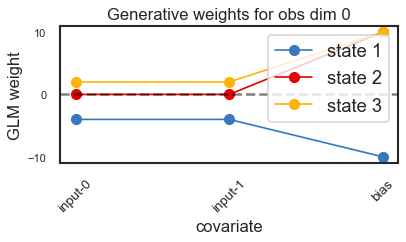

In [3]:
# print(true_hmm.observations.Ws)
print(true_hmm.observations.mus)
# print(true_hmm.observations.Sigmas)
# print(dir(true_hmm.observations))
print(inpt[:10])
print(inpt.shape)

# Plot generative parameters:
mus=true_hmm.observations.mus
# sigmas=true_hmm.observations.sigmas
# true_hmm.observations.sigmas = np.diag(sigmas)
gen_weights=true_hmm.observations.Wks

fig = plt.figure(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(2, 2, 1)
# cols = ['#ff7f00', '#4daf4a', '#377eb8']
for k in range(num_states):
    plt.plot(range(input_dim+1), np.append(gen_weights[k][0],mus[k][0]), marker='o',
             color=colors[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks(np.arange(input_dim+1),np.append(["input-"+str(i) for i in range(input_dim)],'bias'), fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights for obs dim 0", fontsize = 15)

In [4]:
# Sample some data from the HMM
true_states, obs = true_hmm.sample(time_bins, input=inpt)
true_ll = true_hmm.log_probability(obs)

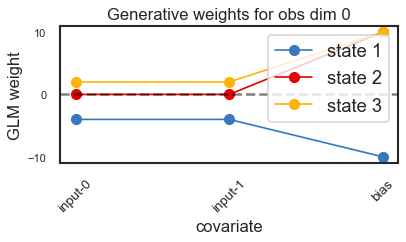

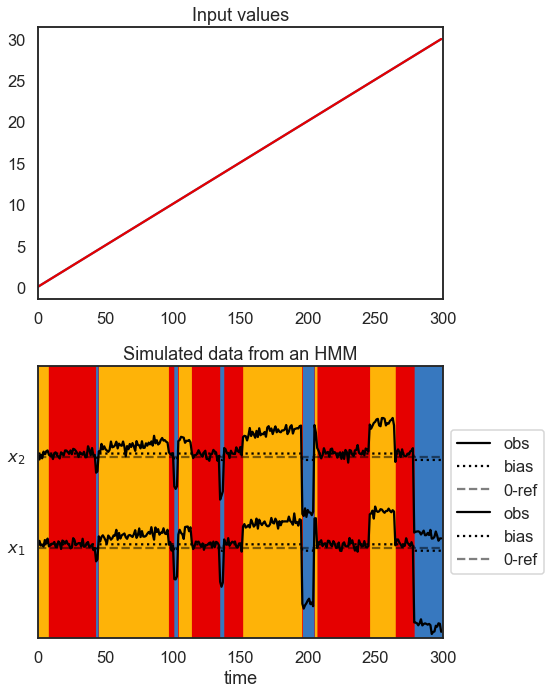

In [5]:
# Plot generative parameters:
mus=true_hmm.observations.mus
# sigmas=true_hmm.observations.sigmas
# true_hmm.observations.sigmas = np.diag(sigmas)
gen_weights=true_hmm.observations.Wks



fig = plt.figure(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(2, 2, 1)
# cols = ['#ff7f00', '#4daf4a', '#377eb8']
for k in range(num_states):
    plt.plot(range(input_dim+1), np.append(gen_weights[k][0],mus[k][0]), marker='o',
             color=colors[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks(np.arange(input_dim+1),np.append(["input-"+str(i) for i in range(input_dim)],'bias'), fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights for obs dim 0", fontsize = 15)


# Plot the data and the smoothed data
lim = 1.05 * abs(obs).max()
plt.figure(figsize=(8, 10))
plt.subplot(211)
for i in range(input_dim):
    plt.plot(inpt[:,i], color=colors[i])
plt.title("Input values")
plt.xlim(0, time_bins)

plt.subplot(212)
for d in range(obs_dim):
    plt.imshow(true_states[None,:],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (obs_dim)*lim))
    Ey = true_hmm.observations.mus[true_states]
    plt.plot(obs[:,d] + lim * d, '-k',label='obs')
    plt.plot(Ey[:,d] + lim * d, ':k',label='bias')
    plt.plot(0*Ey[:,d] +lim * d, '--k', alpha=0.5,label='0-ref')
    plt.xlim(0, time_bins)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("time")
plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])
plt.title("Simulated data from an HMM")

plt.tight_layout()
if save_figures:
    plt.savefig("hmm_2.pdf")
    
# plt.figure(figsize=(6, 6))
# for k in range(num_states):
#     plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
#     plt.plot(obs[true_states==k, 0], obs[true_states==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
# plt.plot(obs[:,0], obs[:,1], '-k', lw=1, alpha=.25)
# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")
# plt.title("Observation Distributions")

# if save_figures:
#     plt.savefig("hmm_1.pdf")

## 3. Fit GLM-HMM and perform recovery analysis

### 3a. Maximum Likelihood Estimation

Now we instantiate a new GLM-HMM and check that we can recover the generative parameters in simulated data:

In [6]:
new_glmhmm = ssm.HMM(num_states, obs_dim, M=input_dim, input=inpt,observations="input_driven_obs_gaussian", transitions="standard")

N_iters = 10000 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(obs, inputs=inpt, method="em", num_iters=N_iters, tolerance=10**-6)

  0%|          | 0/10000 [00:00<?, ?it/s]

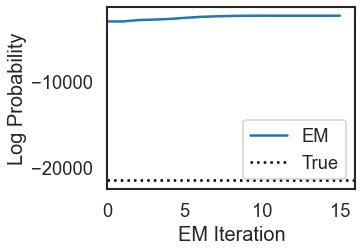

In [7]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

### 3b. Retrieved parameters

Compare retrieved weights and transition matrices to generative parameters. To do this, we may first need to permute the states of the fit GLM-HMM relative to the
generative model.  One way to do this uses the `find_permutation` function from `ssm`:

In [11]:
new_glmhmm.permute(find_permutation(true_states, new_glmhmm.most_likely_states(obs, input=inpt)))

Now plot generative and retrieved weights for GLMs

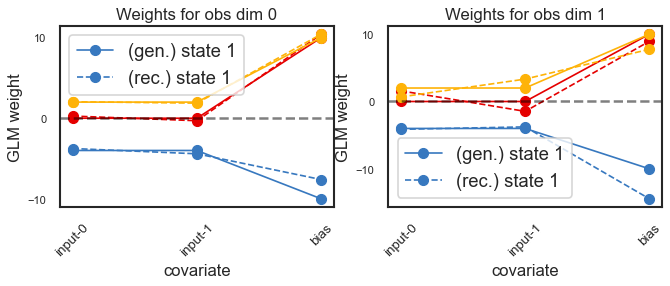

In [15]:
# Plot generative parameters:
mus=true_hmm.observations.mus
gen_weights=true_hmm.observations.Wks
recovered_weights = new_glmhmm.observations.Wks
recovered_mus=new_glmhmm.observations.mus

fig = plt.subplots(1, gen_weights.shape[1], sharey='all', figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')
for iC in range(gen_weights.shape[1]):
    plt.subplot(1, gen_weights.shape[1]+1, iC+1)
    for k in range(num_states):
        if k==0:
            plt.plot(range(input_dim+1), np.append(gen_weights[k][iC],mus[k][iC]), marker='o',
                     color=colors[k], linestyle='-',
                     lw=1.5, label="(gen.) state " + str(k+1))
            plt.plot(range(input_dim+1), np.append(recovered_weights[k][iC],recovered_mus[k][iC]), marker='o',
                     color=colors[k], linestyle='--',
                     lw=1.5, label="(rec.) state " + str(k+1))
        else:
            plt.plot(range(input_dim+1), np.append(gen_weights[k][iC],mus[k][iC]), marker='o',
                     color=colors[k], linestyle='-',
                     lw=1.5)
            plt.plot(range(input_dim+1), np.append(recovered_weights[k][iC],recovered_mus[k][iC]), marker='o',
                     color=colors[k], linestyle='--',
                     lw=1.5)    
    plt.yticks(fontsize=10)
    plt.ylabel("GLM weight", fontsize=15)
    plt.xlabel("covariate", fontsize=15)
#     plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
    plt.xticks(np.arange(input_dim+1),np.append(["input-"+str(i) for i in range(input_dim)],'bias'), fontsize=12, rotation=45)
    plt.axhline(y=0, color="k", alpha=0.5, ls="--")
    plt.legend()
    plt.title('Weights for obs dim {}'.format(iC), fontsize = 15)

Now plot generative and retrieved transition matrices

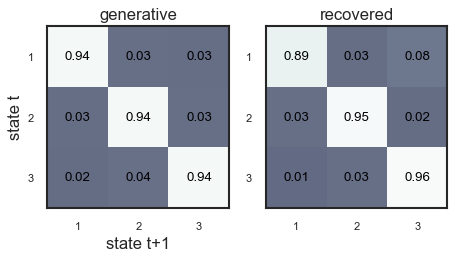

In [17]:
gen_trans_mat = np.exp(true_hmm.transitions.log_Ps)
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)


fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("generative", fontsize = 15)


plt.subplot(1, 2, 2)
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


### 3c. Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [30]:
# Get expected states:
posterior_probs = new_glmhmm.expected_states(data=obs, input=inpt)[0]

Text(0, 0.5, 'true state')

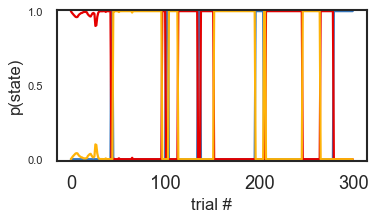

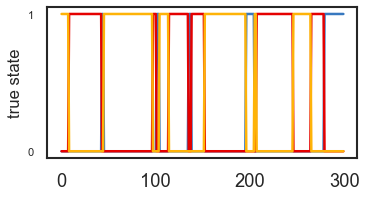

In [33]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[:, k], label="State " + str(k + 1), lw=2,
             color=colors[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)

# overlay true state sequence
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
for k in range(num_states):
    plt.plot(true_states[:]==k,color=colors[k])
plt.yticks(None, fontsize = 10)
plt.yticks([0, 1], fontsize = 10)
plt.ylabel("true state", fontsize = 15)
